# Imports

In [60]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 400

#Preprocessing libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Modelling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier

#Metrics libraries
from sklearn.metrics import confusion_matrix, RocCurveDisplay,roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score

# Null Model

For our first model, we will use the average WnpPresent as our probability for each trap.

Since there are some satellite traps in the test data that are not in the train data, we will assume that the probability of WnvPresent is the same as the main trap. (e.g. T002A's probability will be equal to T002)

For all other traps that are in the test but not in the train data will be set to 0.

In [2]:
df_null = pd.read_pickle('../data/train_with_weather.plk')

In [3]:
test = pd.read_pickle('../data/test_with_weather.plk')

In [4]:
df_null[['Trap','WnvPresent']].groupby(by=['Trap']).mean()[['WnvPresent']]

,WnvPresent
Trap,
T001,0.000000
T002,0.102041
T003,0.123894
T004,0.000000
T005,0.142857
...,...
T236,0.031250
T237,0.000000
T238,0.000000


In [5]:
trap_probas = df_null[['Trap','WnvPresent']].groupby(by=['Trap']).mean()[['WnvPresent']]

In [6]:
test['Trap'].value_counts()

T009     1528
T035     1520
T900     1468
T002      857
T008      822
         ... 
T219      760
T161      760
T088      760
T085      760
T054C     760
Name: Trap, Length: 149, dtype: int64

In [7]:
test[['Trap','Latitude','Longitude']][test['Trap']=='T054']

,Trap,Latitude,Longitude
64,T054,41.921965,-87.632085
65,T054,41.921965,-87.632085
66,T054,41.921965,-87.632085
67,T054,41.921965,-87.632085
68,T054,41.921965,-87.632085
...,...,...,...
115152,T054,41.921965,-87.632085
115153,T054,41.921965,-87.632085
115154,T054,41.921965,-87.632085
115155,T054,41.921965,-87.632085


In [8]:
test['Trap']=test['Trap'].str[:4]

In [9]:
test[['Trap','Latitude','Longitude']]

,Trap,Latitude,Longitude
0,T002,41.954690,-87.800991
1,T002,41.954690,-87.800991
2,T002,41.954690,-87.800991
3,T002,41.954690,-87.800991
4,T002,41.954690,-87.800991
...,...,...,...
116288,T054,41.925652,-87.633590
116289,T054,41.925652,-87.633590
116290,T054,41.925652,-87.633590
116291,T054,41.925652,-87.633590


In [10]:
null = test.join(trap_probas, on='Trap')[['Id','WnvPresent']].set_index('Id')

In [11]:
null.fillna(0,inplace=True)

In [12]:
null.to_csv('../data/kagglesubmissions/null.csv')

The null ROC AUC score from Kaggle is 0.602.

# Logistic Regression

## Data Preparation

In [13]:
df_logreg = pd.read_pickle('../data/train_with_weather.plk')

In [14]:
test = pd.read_pickle('../data/test_with_weather.plk')

In [15]:
# Creating the day of year feature
df_logreg = df_logreg.assign(dayofyear=df_logreg['Date'].dt.dayofyear)

In [16]:
df_logreg.select_dtypes('number').columns

Index(['Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'PrecipTotal', 'BCFG', 'BR', 'DZ', 'FG',
       'FG+', 'FU', 'GR', 'HZ', 'MIFG', 'RA', 'SN', 'SQ', 'TS', 'TSRA', 'VCFG',
       'VCTS', 'Tmax2', 'Tmin2', 'Tavg2', 'Depart2', 'DewPoint2',
       'PrecipTotal2', 'BCFG2', 'BR2', 'DZ2', 'FG2', 'FG+2', 'FU2', 'GR2',
       'HZ2', 'MIFG2', 'RA2', 'SN2', 'SQ2', 'TS2', 'TSRA2', 'VCFG2', 'VCTS2',
       'dayofyear'],
      dtype='object')

In [17]:
def encode(X,ss_features=[]):
    coltrans1 = ColumnTransformer([
        ('ss', StandardScaler(),ss_features)
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False)
    coltrans2 = ColumnTransformer([
        ('ohe', OneHotEncoder(sparse_output=False, drop='first',handle_unknown='ignore'),['Trap','Species'])
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False)
    X_enc = pd.DataFrame(coltrans1.fit_transform(X),columns=coltrans1.get_feature_names_out())
    X_enc = pd.DataFrame(coltrans2.fit_transform(X_enc),columns=coltrans2.get_feature_names_out())
    return X_enc, coltrans1, coltrans2

In [18]:
features = ['Trap','DewPoint','Tmin','TS','RA','Longitude','dayofyear','Species']

In [19]:
X = df_logreg[features]
y = df_logreg['WnvPresent']

In [20]:
#Features to standard scale
ss_features = ['Tmin']

In [21]:
X,coltrans1,coltrans2 = encode(X, ss_features)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)

In [23]:
logreg = LogisticRegression(max_iter=1000, class_weight={0: 1, 1: 20})
logreg.fit(X_train,y_train)

LogisticRegression(class_weight={0: 1, 1: 20}, max_iter=1000)

In [24]:
logreg.predict(X_test)

array([0, 0, 1, ..., 1, 0, 1], dtype=int8)

In [25]:
preds = logreg.predict_proba(X_test)[:,1]

In [26]:
def roc(y_test, preds):
  print(f'ROC AUC score  = {roc_auc_score(y_test,preds)}')
  display = RocCurveDisplay.from_predictions(y_test.astype(int),preds)
  plt.show()
  return

ROC AUC score  = 0.8429825756536253


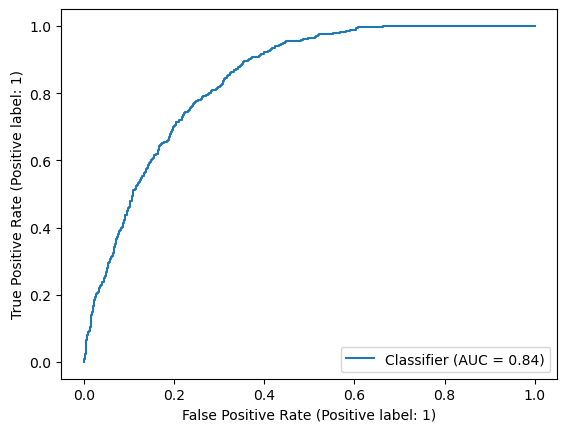

In [27]:
roc(y_train,logreg.predict_proba(X_train)[:,1])

ROC AUC score  = 0.8018200113750711


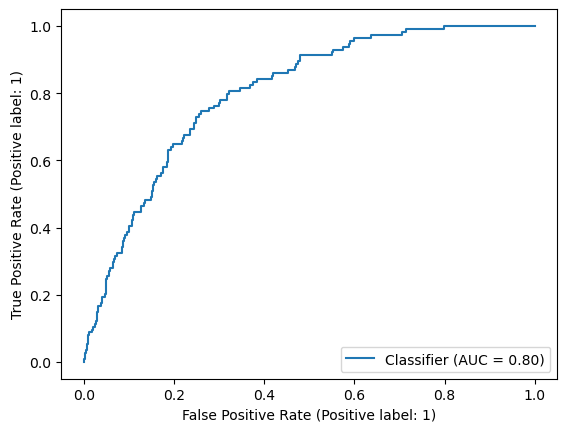

In [28]:
roc(y_test, logreg.predict_proba(X_test)[:,1])

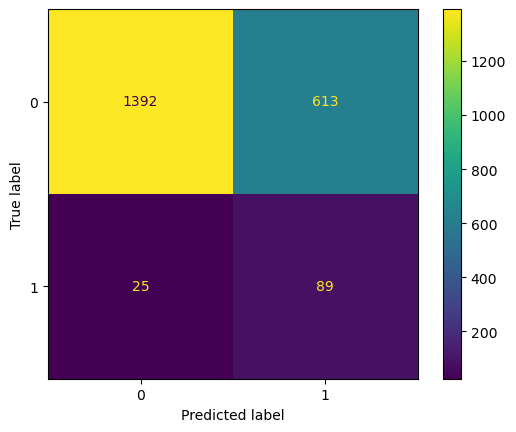

In [29]:
cm1 = confusion_matrix(y_test, logreg.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test, logreg.predict(X_test)).ravel()
disp1 = ConfusionMatrixDisplay(cm1)
disp1.plot();

In [30]:
test = test.assign(dayofyear=pd.to_datetime(test['Date']).dt.dayofyear)
X_validation = test[features]
X_validation_enc = pd.DataFrame(coltrans1.transform(X_validation),columns=coltrans1.get_feature_names_out())
X_validation_enc = pd.DataFrame(coltrans2.transform(X_validation_enc),columns=coltrans2.get_feature_names_out())

C:\Users\hammi\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
logreg.predict_proba(X_validation_enc)[:,1]

array([0.49165519, 0.29279256, 0.57141461, ..., 0.20870671, 0.24471428,
       0.24471428])

In [32]:
preds = logreg.predict_proba(X_validation_enc)[:,1]

In [33]:
test['WnvPresent'] = preds.T

In [34]:
test.loc[(~test['Species'].str.contains('RESTUANS'))&(~test['Species'].str.contains('PIPIENS')),['WnvPresent']]=0

In [35]:
test[['Id','WnvPresent']].to_csv('../data/kagglesubmissions/logreg.csv', index=False)

The Kaggle score for this model is 0.707.

# Logistic Regression with Hyper Parameter Tuning

In [36]:
grid_logreg = GridSearchCV(estimator=LogisticRegression(),
                   param_grid = {
                       "penalty": ['l1', 'l2'], 
                       "C": [0.001, 0.01, 0.5, 1.0], 
                       "random_state": [42],
                        "solver": ['liblinear'], 
                       "max_iter": [1000],
                       "class_weight":['balanced', {0:1,1:10}]},
                    cv=5,
                    verbose = 1,
                    scoring='roc_auc'
                   )

In [37]:
grid_logreg.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.5, 1.0],
                         'class_weight': ['balanced', {0: 1, 1: 10}],
                         'max_iter': [1000], 'penalty': ['l1', 'l2'],
                         'random_state': [42], 'solver': ['liblinear']},
             scoring='roc_auc', verbose=1)

In [38]:
logreg2 = grid_logreg.best_estimator_

ROC AUC score  = 0.8409902936252308


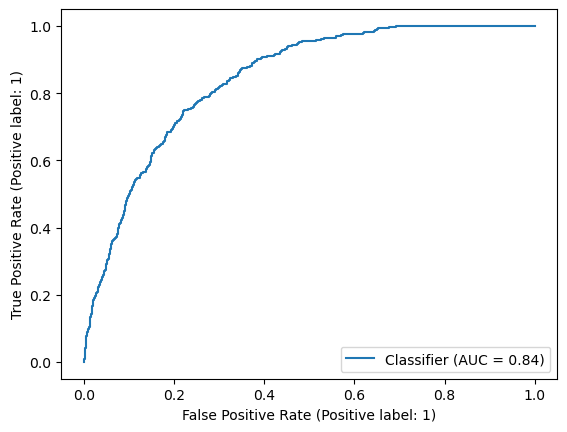

In [39]:
roc(y_train,logreg2.predict_proba(X_train)[:,1])

ROC AUC score  = 0.8093756835980226


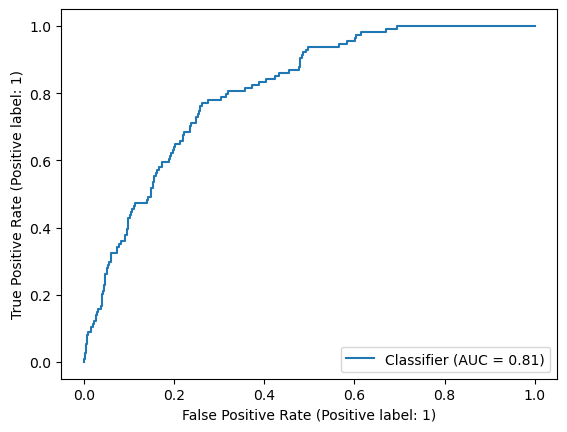

In [40]:
roc(y_test,logreg2.predict_proba(X_test)[:,1])

In [41]:
grid_logreg.best_params_

{'C': 0.5,
 'class_weight': {0: 1, 1: 10},
 'max_iter': 1000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear'}

In [42]:
test = test.assign(dayofyear=pd.to_datetime(test['Date']).dt.dayofyear)
X_validation = test[features]
X_validation_enc = pd.DataFrame(coltrans1.transform(X_validation),columns=coltrans1.get_feature_names_out())
X_validation_enc = pd.DataFrame(coltrans2.transform(X_validation_enc),columns=coltrans2.get_feature_names_out())

C:\Users\hammi\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [43]:
logreg2.predict_proba(X_validation_enc)[:,1]

array([0.34605067, 0.18326157, 0.42231514, ..., 0.15925466, 0.18114187,
       0.18114187])

In [44]:
preds = logreg2.predict_proba(X_validation_enc)[:,1]

In [45]:
test['WnvPresent'] = preds.T

In [46]:
test[['Id','WnvPresent']].to_csv('../data/kagglesubmissions/logreg2.csv', index=False)

The Kaggle score for this model is 0.707.

# Insights from Logistic Regression Model

In [47]:
feature_importances = pd.DataFrame(logreg2.coef_, columns=coltrans2.get_feature_names_out()).T.sort_values(by=[0]).rename(columns={0:'feature_importances'})

<AxesSubplot:>

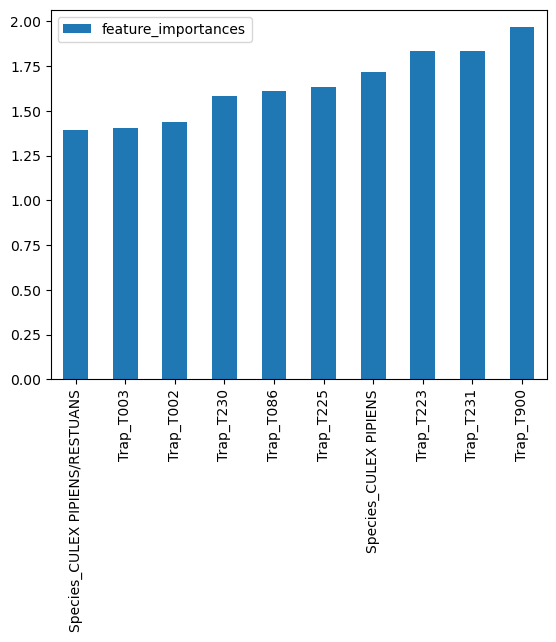

In [48]:
feature_importances[-10:].plot(kind='bar')

## Where to spray at different probabilities

In [49]:
test[test['WnvPresent']>0.8]['Trap'].unique()

array(['T086', 'T900', 'T223', 'T225', 'T231', 'T002', 'T230', 'T003',
       'T235', 'T096', 'T228', 'T233', 'T045', 'T143', 'T009', 'T011',
       'T028', 'T090', 'T147', 'T008', 'T013', 'T095', 'T061', 'T066',
       'T070', 'T081', 'T082', 'T114', 'T115', 'T215', 'T103', 'T027',
       'T221', 'T903', 'T227', 'T054C'], dtype=object)

In [50]:
len(test[test['WnvPresent']>0.8]['Trap'].unique())

36

In [51]:
test[test['WnvPresent']>0.5]['Trap'].unique()

array(['T900', 'T223', 'T231', 'T002', 'T086', 'T003', 'T225', 'T230',
       'T045', 'T096', 'T143', 'T009', 'T011', 'T028', 'T147', 'T008',
       'T095', 'T061', 'T066', 'T082', 'T114', 'T115', 'T215', 'T103',
       'T027', 'T903', 'T227', 'T228', 'T233', 'T235', 'T054C', 'T054',
       'T016', 'T090', 'T013', 'T014', 'T070', 'T081', 'T221', 'T226',
       'T048', 'T033', 'T089', 'T135', 'T151', 'T158', 'T220', 'T012',
       'T047', 'T030', 'T035', 'T039', 'T065', 'T073', 'T083', 'T138',
       'T128', 'T232', 'T031', 'T142', 'T162', 'T006', 'T037', 'T085',
       'T084', 'T005', 'T067', 'T155', 'T097', 'T200A', 'T200B', 'T001',
       'T090A', 'T090B', 'T090C', 'T128A', 'T218A', 'T218C', 'T218B',
       'T065A', 'T152', 'T154', 'T040', 'T144', 'T160', 'T077', 'T224',
       'T002A', 'T002B', 'T234', 'T015', 'T074', 'T080', 'T107', 'T094B',
       'T159', 'T094', 'T218', 'T004', 'T062', 'T076', 'T079', 'T063',
       'T209', 'T212', 'T078', 'T222', 'T229', 'T237', 'T238'],
      d

In [52]:
len(test[test['WnvPresent']>0.5]['Trap'].unique())

110

# Decision Tree

In [83]:
df_dt = pd.read_pickle('../data/train_with_weather.plk')
test = pd.read_pickle('../data/test_with_weather.plk')

In [84]:
features = ['Trap','Species','DewPoint','Tmin','TS','RA','Longitude']
ss_features = ['Tmin']

In [85]:
X = df_dt[features]
y = df_dt['WnvPresent']
X,coltrans1,coltrans2 = encode(X, ss_features)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,random_state=42, stratify=y)

In [113]:
grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                   param_grid = {
                       "max_depth" : [2,3,5,7],
                       "min_samples_split" : [5,10,15,20],
                       "min_samples_leaf" : [2,3,4,5,6],
                       "ccp_alpha" : [0,.001,.01,.1,1,10],
                       "class_weight": [None,'balanced',{0:1,1:10}]},
                    cv=5,
                    verbose = 1,
                    scoring='roc_auc'
                   )

In [114]:
grid.fit(X_train2, y_train2)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced', {0: 1, 1: 10}],
                         'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='roc_auc', verbose=1)

In [115]:
dt = grid.best_estimator_

In [116]:
grid.best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'max_depth': 7,
 'min_samples_leaf': 6,
 'min_samples_split': 15}

ROC AUC score  = 0.8576330487054531


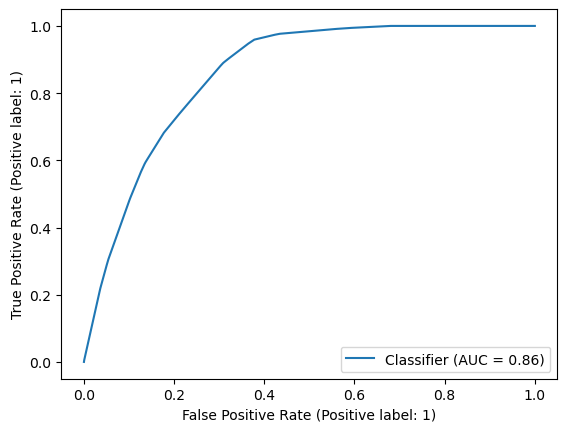

In [117]:
roc(y_train2,dt.predict_proba(X_train2)[:,1])

ROC AUC score  = 0.8193157457234107


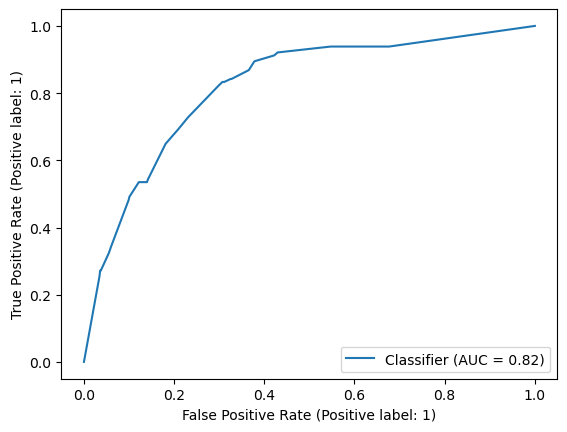

In [118]:
roc(y_test2,dt.predict_proba(X_test2)[:,1])

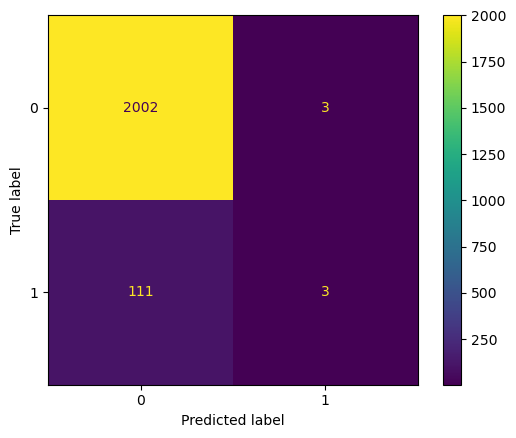

In [95]:
cm2 = confusion_matrix(y_test2, dt.predict(X_test2))
tn, fp, fn, tp = confusion_matrix(y_test2, dt.predict(X_test2)).ravel()
disp1 = ConfusionMatrixDisplay(cm2)
disp1.plot();

In [96]:
test = test.assign(dayofyear=pd.to_datetime(test['Date']).dt.dayofyear)
X_validation = test[features]
X_validation_enc = pd.DataFrame(coltrans1.transform(X_validation),columns=coltrans1.get_feature_names_out())
X_validation_enc = pd.DataFrame(coltrans2.transform(X_validation_enc),columns=coltrans2.get_feature_names_out())

C:\Users\hammi\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [97]:
dt.predict(X_validation_enc)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [98]:
preds = dt.predict_proba(X_validation_enc)[:,1]

In [99]:
test['WnvPresent'] = preds.T

In [100]:
test.loc[(~test['Species'].str.contains('RESTUANS'))&(~test['Species'].str.contains('PIPIENS')),['WnvPresent']]=0

In [101]:
test[['Id','WnvPresent']].to_csv('../data/kagglesubmissions/rt.csv',index=False)

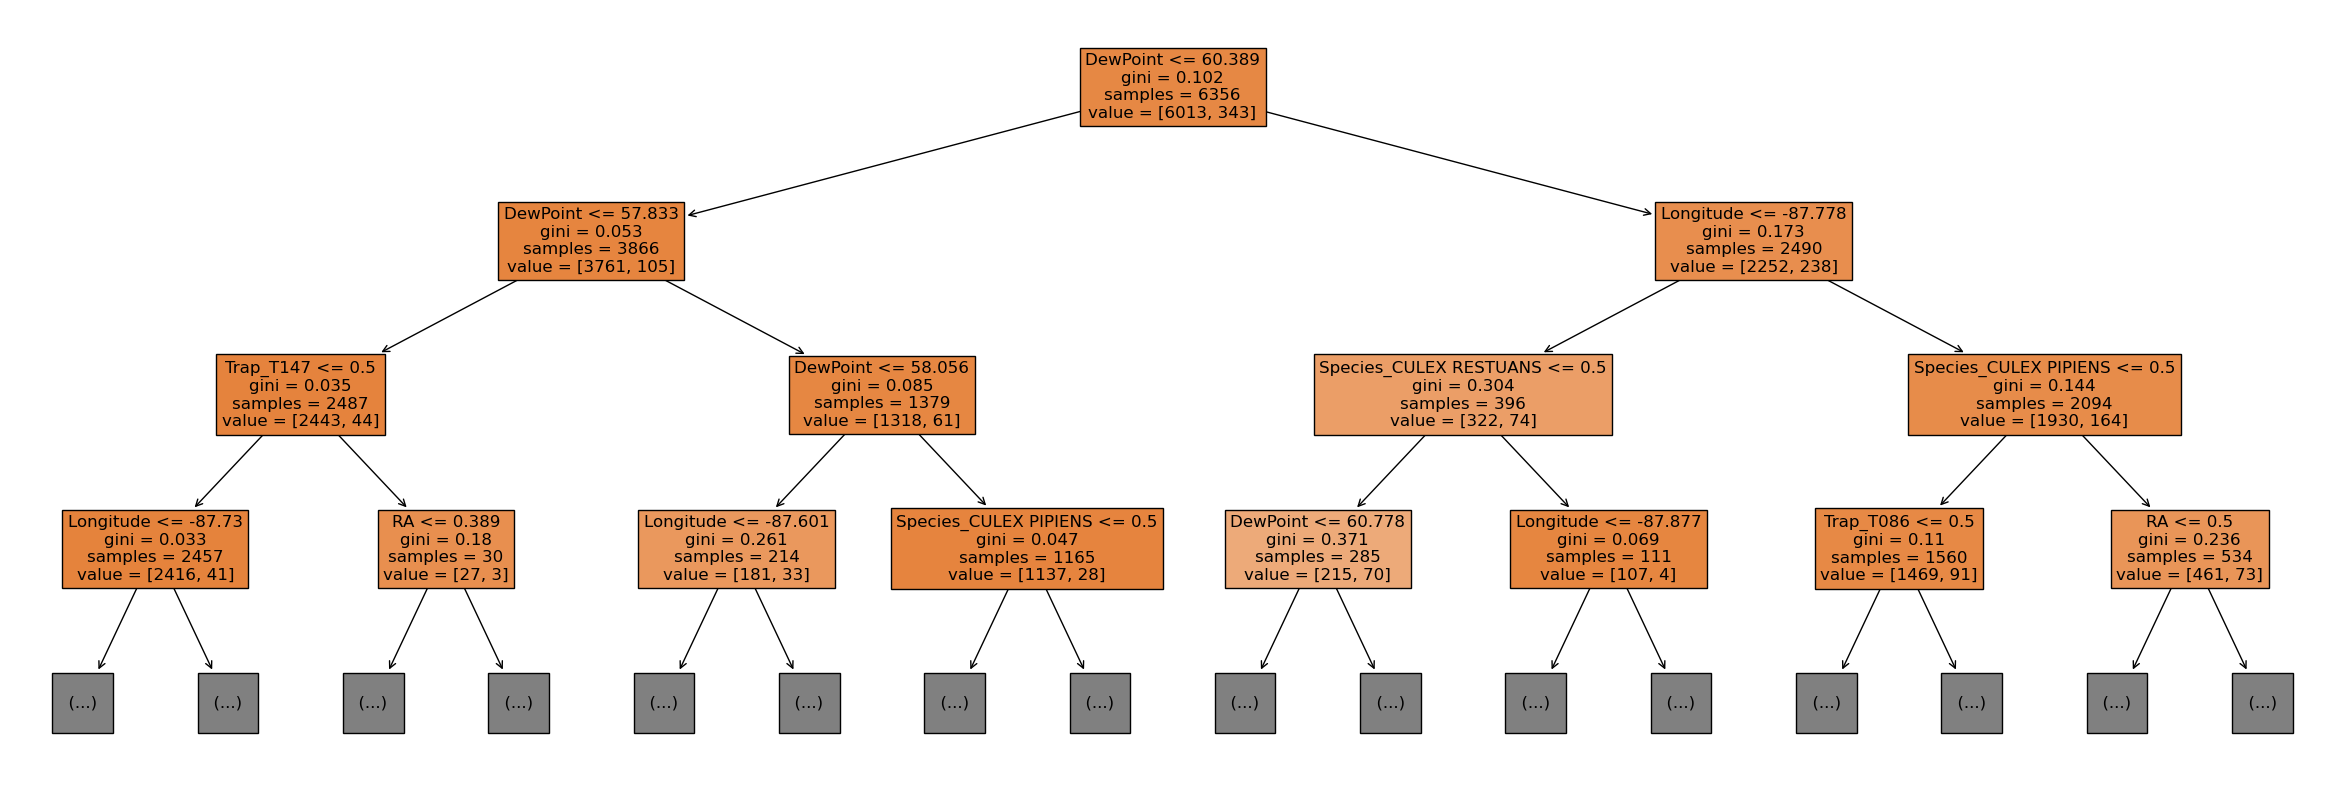

In [109]:
plt.figure(figsize = (30, 10),dpi=100)

# Plot our tree.
plot_tree(grid.best_estimator_,
          feature_names = X_train2.columns,
          filled = True,
         fontsize=12,
         max_depth=3);

The Kaggle score for this model is 0.645.

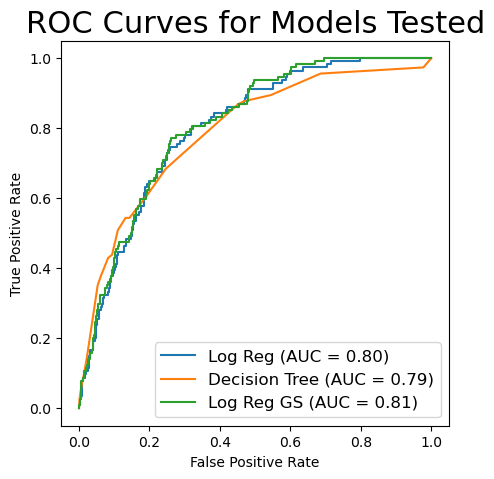

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
disp1 = RocCurveDisplay.from_estimator(logreg, X_test, y_test, ax=ax, name='Log Reg')
disp2 = RocCurveDisplay.from_estimator(dt, X_test2, y_test2, ax=ax, name='Decision Tree')
disp3 = RocCurveDisplay.from_estimator(logreg2, X_test, y_test, ax=ax, name='Log Reg GS')
ax.set_title('ROC Curves for Models Tested', fontsize=22)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.legend(fontsize=12)
plt.show()